BLG 307 - YAPAY ZEKA SİSTEMLERİ PROJE TESLİMİ:

Adınız: Ali

Soyadınız: Uçma

Okul Numaranız: 2212721007

GitHub Repo Bağlantısı: https://github.com/Alu0320/genetik_optimizasyon

**Kullanılan Kütüphaneler**

In [103]:
import random
import numpy as np
import matplotlib.pyplot as plt

**🎯 Amaç (Objective) Fonksiyonu**

Maksimize edilmek istenen matematiksel modeldir.

x1 ve x2 iki farklı reaktifi temsil etmektedir.

Lineer terimler, etkileşim terimi ve ceza terimi içermektedir.

In [104]:
def objective_function(x1, x2):
    return 3*x1 + 2*x2 + x1*x2 - 0.5*(x2**2)


** Kısıtların Tanımlanması**

Karışım oranlarının fiziksel ve senaryo gereği sınırları vardır.

Geçerli bireyler bu kısıtları sağlamak zorundadır.

Kısıtlar algoritmanın tüm aşamalarında kontrol edilir.

In [105]:
def constraints_ok(x1, x2):
    if x1 < 25:
        return False
    if x1 < 10 or x1 > 80:
        return False
    if x2 < 10 or x2 > 80:
        return False
    if x1 + x2 > 100:
        return False
    return True

** Birey (Individual) Oluşturma**

Sürekli değerli rastgele bireyler oluşturulur.

Kısıtları sağlamayan bireyler elenir.

Başlangıç popülasyonu tamamen geçerli bireylerden oluşur.

In [106]:
def create_individual():
    while True:
        x1 = random.uniform(10, 80)
        x2 = random.uniform(10, 80)
        if constraints_ok(x1, x2):
            return [x1, x2]

**Popülasyon Oluşturma**

Popülasyon, bireylerin listesi şeklinde tanımlanmıştır.

Varsayılan popülasyon boyutu 40’tır.

In [107]:
def create_population(size):
    return [create_individual() for _ in range(size)]


**Uygunluk (Fitness) Fonksiyonu**

Her bireyin başarımı amaç fonksiyonu ile ölçülür.

Daha yüksek değer = daha iyi çözüm.

In [108]:
def fitness(individual):
    return objective_function(individual[0], individual[1])


**Seçilim – Turnuva Seçimi**

Rastgele seçilen bireyler arasından en iyisi ebeveyn olur.

Turnuva seçimi, iyi bireyleri korurken çeşitliliği sürdürür.

In [109]:
def tournament_selection(population, k=3):
    selected = random.sample(population, k)
    selected.sort(key=lambda ind: fitness(ind), reverse=True)
    return selected[0]


 **Çaprazlama (Crossover)**

Aritmetik çaprazlama yöntemi kullanılmıştır.

Sürekli değişkenler için uygundur.

Kısıt ihlali durumunda birey yeniden üretilir.

In [110]:
def crossover(parent1, parent2):
    alpha = random.random()
    child1 = [
        alpha * parent1[0] + (1 - alpha) * parent2[0],
        alpha * parent1[1] + (1 - alpha) * parent2[1]
    ]
    child2 = [
        (1 - alpha) * parent1[0] + alpha * parent2[0],
        (1 - alpha) * parent1[1] + alpha * parent2[1]
    ]

    if not constraints_ok(child1[0], child1[1]):
        child1 = create_individual()
    if not constraints_ok(child2[0], child2[1]):
        child2 = create_individual()

    return child1, child2


**Mutasyon**

%10 olasılıkla küçük rastgele değişimler uygulanır.

Arama uzayında çeşitlilik sağlar.

Kısıt ihlali kontrol edilir.

In [111]:
def mutate(individual, mutation_rate=0.1):
    if random.random() < mutation_rate:
        individual[0] += random.uniform(-5, 5)
        individual[1] += random.uniform(-5, 5)

    if not constraints_ok(individual[0], individual[1]):
        return create_individual()

    return individual


**Genetik Algoritma Ana Döngüsü**

Seçilim, çaprazlama ve mutasyon adımları her nesilde uygulanır.

Her neslin en iyi fitness değeri kaydedilir.

Algoritma belirlenen nesil sayısı kadar çalışır.

In [112]:
def genetic_algorithm(pop_size=40, generations=80):
    population = create_population(pop_size)
    best_values = []

    for gen in range(generations):
        new_population = []

        for _ in range(pop_size // 2):
            p1 = tournament_selection(population)
            p2 = tournament_selection(population)

            c1, c2 = crossover(p1, p2)
            c1 = mutate(c1)
            c2 = mutate(c2)

            new_population.append(c1)
            new_population.append(c2)

        population = new_population

        best_ind = max(population, key=lambda ind: fitness(ind))
        best_values.append(fitness(best_ind))

        print(f"Generasyon {gen+1}: En iyi çözüm = {fitness(best_ind):.3f}")

    final_best = max(population, key=lambda ind: fitness(ind))
    return final_best, best_values


**En İyi Çözümün Yazdırılması**

Algoritmanın bulduğu en iyi birey ekrana yazdırılır.

Karışım oranları ve maksimum amaç fonksiyonu değeri gösterilir.

In [113]:
best_solution, best_graph = genetic_algorithm()

print("\n--- EN İYİ ÇÖZÜM ---")
print("x1:", best_solution[0])
print("x2:", best_solution[1])
print("En yüksek y:", fitness(best_solution))


Generasyon 1: En iyi çözüm = 1858.794
Generasyon 2: En iyi çözüm = 1858.794
Generasyon 3: En iyi çözüm = 1886.437
Generasyon 4: En iyi çözüm = 1924.188
Generasyon 5: En iyi çözüm = 1924.186
Generasyon 6: En iyi çözüm = 1920.403
Generasyon 7: En iyi çözüm = 1918.832
Generasyon 8: En iyi çözüm = 1912.816
Generasyon 9: En iyi çözüm = 1912.496
Generasyon 10: En iyi çözüm = 1912.241
Generasyon 11: En iyi çözüm = 1912.196
Generasyon 12: En iyi çözüm = 1912.195
Generasyon 13: En iyi çözüm = 1912.190
Generasyon 14: En iyi çözüm = 1912.187
Generasyon 15: En iyi çözüm = 1912.183
Generasyon 16: En iyi çözüm = 1912.183
Generasyon 17: En iyi çözüm = 1912.183
Generasyon 18: En iyi çözüm = 1912.183
Generasyon 19: En iyi çözüm = 1912.183
Generasyon 20: En iyi çözüm = 1923.765
Generasyon 21: En iyi çözüm = 1926.432
Generasyon 22: En iyi çözüm = 1926.515
Generasyon 23: En iyi çözüm = 1926.513
Generasyon 24: En iyi çözüm = 1926.548
Generasyon 25: En iyi çözüm = 1926.548
Generasyon 26: En iyi çözüm = 1926

**Sonuçların Görselleştirilmesi**

Nesiller boyunca en iyi çözümün gelişimi grafikle sunulur.

Algoritmanın yakınsama davranışı analiz edilebilir.

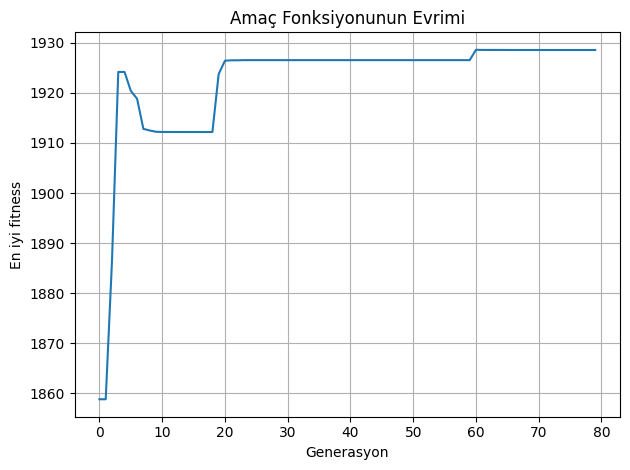

In [114]:
plt.plot(best_graph)
plt.xlabel("Generasyon")
plt.ylabel("En iyi fitness")
plt.title("Amaç Fonksiyonunun Evrimi")
plt.grid(True)
plt.tight_layout()
plt.show()
